In [1]:
!pip install catboost optuna shap boto3 mlflow prettytable -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
!pip install --upgrade jinja2

In [22]:
import os
import re
import time
import json
import joblib
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import (
    HTML,
    Math,
    Markdown
)
import gc
import requests
import geopandas as gpd
from shapely.geometry import Point
from pylab import rcParams
import io
import tqdm
import shap
import warnings
import boto3
from urllib.parse import urlparse
import logging
import mlflow
from mlflow.models import infer_signature

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV
)
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
    Pool
)

from pandas.api.types import CategoricalDtype
from pandas import json_normalize
from prettytable import PrettyTable

warnings.filterwarnings("ignore")
%matplotlib inline

shap.initjs()

In [5]:
def load_config(file_path: str) -> dict:
    with open(file_path) as f:
        return json.load(f)


def create_s3_client(config: dict) -> boto3.client:
    return boto3.client(
        's3',
        aws_access_key_id=config['aws']['access_key_id'],
        aws_secret_access_key=config['aws']['secret_access_key'],
        endpoint_url=config['mlflow']['s3_endpoint_url']
    )


def get_s3_object(s3: boto3.client, config: dict, dataset_name: str) -> dict:
    dataset_key = config['s3']['datasets'][dataset_name]
    return s3.get_object(
        Bucket=config['s3']['bucket'],
        Key=dataset_key
    )


def read_dataset_from_s3(obj: dict) -> pd.DataFrame:
    with obj['Body'] as f:
        buffer = io.BytesIO(f.read())
    return pd.read_parquet(buffer)


def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ["object", "category", "datetime64[ns, UTC]"]:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def convert_columns_to_catg(df: pd.DataFrame, column_list: list[str]) -> None:
    for col in column_list:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6, 2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6, 2))


def create_target_features(df: pd.DataFrame) -> pd.DataFrame:
    df["area_sqm"] = df["price"] / df["area"]
    df["log_area_sqm"] = np.log1p(df["area_sqm"])
    return df


def set_display() -> None:
    """Function sets display options for charts and pd.DataFrames."""
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [20]:
SECRETS = "config_secrets.json"

PARAMS = {
    'depth': 13,
    'colsample_bylevel': 0.4807044219432993,
    'min_child_samples': 1,
    'learning_rate': 0.039239921233057515,
    'l2_leaf_reg': 0.07032952669762758,
    'random_strength': 2.6772674348296995e-07,
    'bootstrap_type': 'MVS',
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'early_stopping_rounds': 100
}

FEATURSE2DROP = [
    "price", "area_sqm", "geo_lat", "geo_lon", "index_right"
]

TARGET = ["log_area_sqm"]

CAT_FEATURES = [
    'region', 'building_type', 'object_type',
    'city', 'osm_city_nearest_name', 'nearest_metro_station', 'apartment_type'
]

N_SPLITS = 3


In [7]:
config = load_config(SECRETS )

os.environ['AWS_ACCESS_KEY_ID'] = config['aws']['access_key_id']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['aws']['secret_access_key']
os.environ['AWS_REGION'] = config['aws']['region']
os.environ['MLFLOW_S3_ENDPOINT_URL'] = config['mlflow']['s3_endpoint_url']
mlflow.set_tracking_uri(config['mlflow']['tracking_uri'])

os.environ['MLFLOW_S3_BUCKET'] = config['s3']['bucket']

datasets = config['s3']['datasets']

s3 = create_s3_client(config)
obj = get_s3_object(s3, config, "dataset")
df = read_dataset_from_s3(obj)

In [15]:
df = reduce_mem_usage(df)
df.info()

Memory usage of dataframe is 103.70 MB
Memory usage after optimization is: 103.70 MB
Decreased by 0.0%
<class 'pandas.core.frame.DataFrame'>
Index: 782258 entries, 0 to 938234
Data columns (total 51 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   price                            782258 non-null  int64  
 1   geo_lat                          782258 non-null  float16
 2   geo_lon                          782258 non-null  float16
 3   region                           782258 non-null  object 
 4   building_type                    782258 non-null  object 
 5   level                            782258 non-null  int8   
 6   levels                           782258 non-null  int8   
 7   rooms                            782258 non-null  int8   
 8   area                             782258 non-null  float16
 9   kitchen_area                     782258 non-null  float16
 10  object_type                   

In [16]:
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
price,782258.000000,10825881.492280,16076137.049026,2800001.000000,5015000.000000,7400000.000000,11276097.500000,2148283647.000000
geo_lat,782258.000000,nan,0.000000,54.312500,55.625000,55.750000,55.843750,56.906250
geo_lon,782258.000000,nan,0.000000,35.250000,37.468750,37.625000,37.843750,40.062500
level,782258.000000,7.825417,5.988519,1.000000,3.000000,6.000000,11.000000,39.000000
levels,782258.000000,14.474029,7.386484,1.000000,9.000000,15.000000,18.000000,39.000000
rooms,782258.000000,1.940304,0.906898,0.000000,1.000000,2.000000,3.000000,9.000000
area,782258.000000,nan,nan,10.000000,40.000000,53.000000,67.500000,845.500000
kitchen_area,782258.000000,nan,0.000000,2.019531,7.500000,10.000000,12.203125,180.000000
index_right,782258.000000,135088.883967,83013.503692,129.000000,57379.000000,129430.000000,213580.000000,275549.000000
osm_amenity_points_in_0.01,782258.000000,112.641563,160.442383,0.000000,32.000000,73.000000,132.000000,1068.000000


In [17]:
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Train Missing %']
for column in df.columns:
    data_type = str(df[column].dtype)
    non_null_count_train= np.round(100 - df[column].count() / df.shape[0]*100, 1)
    table.add_row([column, data_type, non_null_count_train])
print(table)

+---------------------------------+-----------+-----------------+
|             Feature             | Data Type | Train Missing % |
+---------------------------------+-----------+-----------------+
|              price              |   int64   |       0.0       |
|             geo_lat             |  float16  |       0.0       |
|             geo_lon             |  float16  |       0.0       |
|              region             |   object  |       0.0       |
|          building_type          |   object  |       0.0       |
|              level              |    int8   |       0.0       |
|              levels             |    int8   |       0.0       |
|              rooms              |    int8   |       0.0       |
|               area              |  float16  |       0.0       |
|           kitchen_area          |  float16  |       0.0       |
|           object_type           |   object  |       0.0       |
|           index_right           |   int32   |       0.0       |
|         

In [18]:
filtered_features = [i for i in df.columns if (i not in TARGET and i not in FEATURSE2DROP)]
num_features = [i for i in filtered_features if i not in CAT_FEATURES]

print("cat_features :", len(CAT_FEATURES), CAT_FEATURES)
print("num_features :", len(num_features), num_features)
print("targets", TARGET)

cat_features : 7 ['region', 'building_type', 'object_type', 'city', 'osm_city_nearest_name', 'nearest_metro_station', 'apartment_type']
num_features : 40 ['level', 'levels', 'rooms', 'area', 'kitchen_area', 'osm_amenity_points_in_0.01', 'osm_building_points_in_0.01', 'osm_catering_points_in_0.01', 'osm_city_closest_dist', 'osm_city_nearest_population', 'osm_crossing_closest_dist', 'osm_culture_points_in_0.01', 'osm_finance_points_in_0.01', 'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.01', 'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.01', 'osm_shops_points_in_0.01', 'osm_subway_closest_dist', 'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.01', 'osm_transport_stop_closest_dist', 'reform_count_of_houses_1000', 'reform_count_of_houses_500', 'many_offices', 'many_food', 'many_shops', 'many_financial_organizations', 'many_entertainment', 'many_historical_objects', 'many_hotels', 'station_rate', 'many_stations', 'many_culture_objects', 'many_comfort_objects', '

In [ ]:
mlflow.set_experiment("cb_experiment")

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

df = create_target_features(df)
convert_columns_to_catg(df, CAT_FEATURES)

models = []
r2_scores = []
mae_scores = []

X = df[filtered_features].drop(TARGET, axis=1, errors="ignore")
y = df[TARGET]

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=7575)

with mlflow.start_run() as run:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=CAT_FEATURES)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=CAT_FEATURES)

        model = CatBoostRegressor(**PARAMS)
        models.append(model)

        model.fit(train_dataset, eval_set=eval_dataset, verbose=50, use_best_model=True, plot=False)

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2_scores.append(np.mean(model.best_score_["validation"]["R2"]))
        mae_scores.append(mae)

    print("len(clfs):", len(models))
    print("n_splits:", N_SPLITS)

    print("mean R2 score --------->", np.mean(r2_scores))
    print("mean MAE score --------->", np.mean(mae_scores))

    mlflow.log_param("n_splits", N_SPLITS)
    mlflow.log_param("cat_features", CAT_FEATURES)
    mlflow.log_metric("mean R2 score", np.mean(r2_scores))
    mlflow.log_metric("mean MAE score", np.mean(mae_scores))
    mlflow.log_param("CatBoost hyperparameters", PARAMS)

    for i, model in enumerate(models):
        signature = infer_signature(X_test, model.predict(X_test))
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":
            mlflow.catboost.log_model(
                model, "model", artifact_path=f"model_cv_{i}", registered_model_name=f"CatBoostModel_fold_{i}", signature=signature
        )
        else:
            mlflow.catboost.log_model(model, "model", signature=signature)

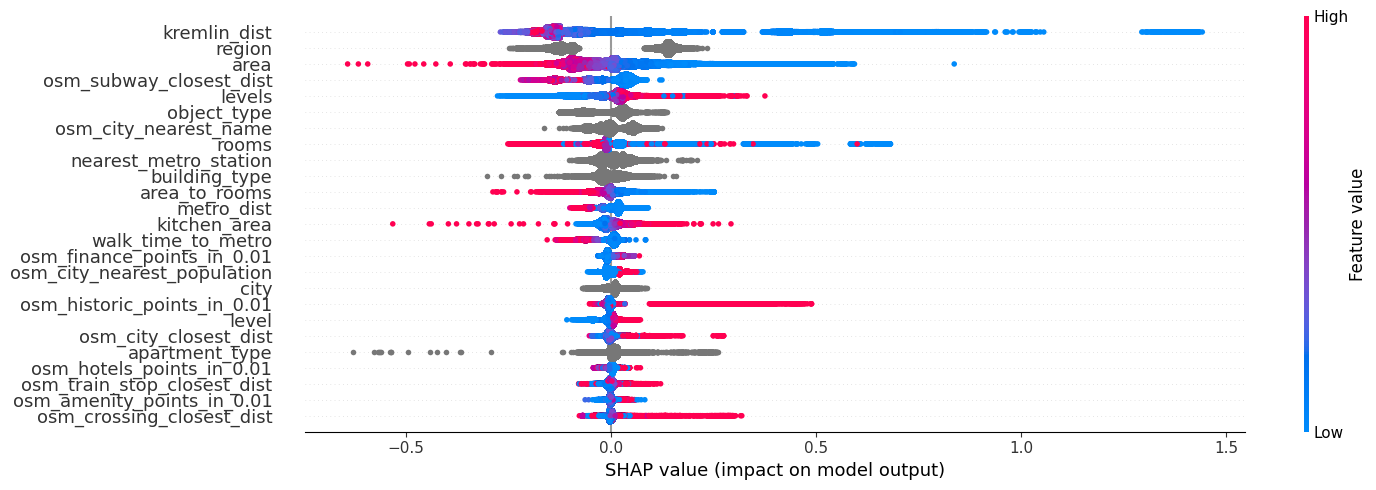

In [23]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=CAT_FEATURES)
shap_values = explainer.shap_values(eval_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_size = (15, 5))